In [24]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image

import time


https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy

In [5]:
torch.manual_seed(0);

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

__Load Dataset__

In [26]:
#IMAGE_SIZE = 16

#Create a transform to resize images and convert to tensor
#composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

composed = transforms.Compose([transforms.ToTensor()])

train_set = datasets.FashionMNIST(root='.fashion/data', train=True, download=True, transform=composed)
test_set  = datasets.FashionMNIST(root='.fashion/data', train=False, download=True, transform=composed)

In [27]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [38]:
def show_data(data_sample):
    #plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')    
    plt.title('y = ' + str(data_sample[1]))

## Question 1
Take a screen shot of  the first three images of the validation dataset  from the code provided . The function show_data

In [56]:
train_set[0][0].size()

torch.Size([1, 28, 28])

IndexError: tuple index out of range

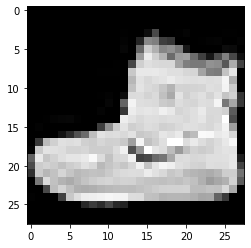

In [39]:
for n in range(3):
    show_data(train_set[n])
    plt.show()

In [34]:
class FashionCNN(nn.Module):
    def __init__(self, Ndim ):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=Ndim, kernel_size=3, padding=1),
            nn.BatchNorm2d(Ndim),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=Ndim, out_channels=Ndim*2, kernel_size=3),
            nn.BatchNorm2d(Ndim*2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features= Ndim*2 *6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out        

In [35]:
model = FashionCNN(32)
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [36]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.48137587308883667, Accuracy: 87.31999969482422%
Iteration: 1000, Loss: 0.31276020407676697, Accuracy: 87.08000183105469%
Iteration: 1500, Loss: 0.2553243339061737, Accuracy: 87.66000366210938%
Iteration: 2000, Loss: 0.2120196521282196, Accuracy: 89.70999908447266%
Iteration: 2500, Loss: 0.10676571726799011, Accuracy: 89.56999969482422%
Iteration: 3000, Loss: 0.17933592200279236, Accuracy: 90.01000213623047%


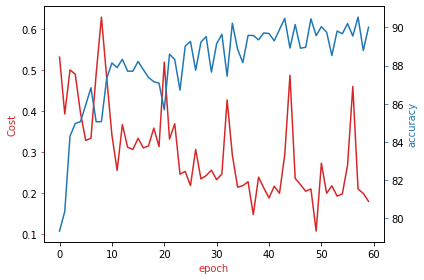

In [37]:
# Plot the loss and accuracy
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
